# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.525629,True,6.965736
1,0.297731,True,5.865002
2,0.833755,False,2.402004
3,-0.245080,False,-1.212799
4,-1.016627,False,-1.995421
...,...,...,...
995,-1.591958,False,-2.851605
996,1.709123,False,4.847076
997,-1.141965,False,-2.455751
998,-0.776968,False,-2.792224


<AxesSubplot:xlabel='v0'>

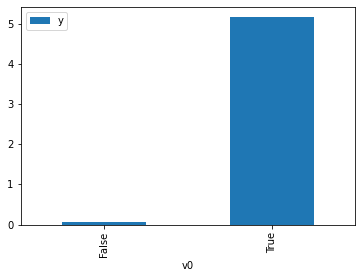

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

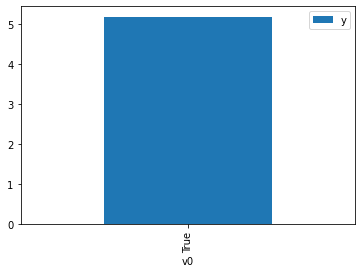

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.110555,False,0.877857,0.474323,2.108266
1,-0.261117,False,0.632827,0.483149,2.069753
2,-0.262210,False,-0.644399,0.483175,2.069642
3,0.726015,False,0.749272,0.459746,2.175115
4,-1.560226,False,-4.770958,0.514046,1.945351
...,...,...,...,...,...
995,-0.991105,False,-4.401180,0.500510,1.997962
996,0.882820,False,1.452944,0.456042,2.192781
997,-0.585689,False,-2.365337,0.490866,2.037216
998,-0.294285,False,-1.937770,0.483938,2.066382


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.296394,True,7.998249,0.553703,1.806022
1,0.010921,True,3.417666,0.523312,1.910906
2,-0.315457,True,4.852574,0.515559,1.939642
3,0.927482,True,8.156602,0.545012,1.834821
4,-0.220592,True,4.914179,0.517813,1.931197
...,...,...,...,...,...
995,1.472212,True,8.215237,0.557834,1.792648
996,1.296882,True,10.096357,0.553715,1.805984
997,-2.234279,True,-3.848106,0.469950,2.127885
998,0.387120,True,7.218330,0.532234,1.878872


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          1.085e+04
Date:                Wed, 03 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:25:25   Log-Likelihood:                         -1397.8
No. Observations:                1000   AIC:                                      2800.
Df Residuals:                     998   BIC:                                      2809.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6550      0.031     85.840      0.000       2.594       2.716
x2             5.0108      0.043    116.858      0.000       4.927       5.095
==============================================================================
Omnibus:                        2.946   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.229   Jarque-Bera (JB):                2.714
Skew:                          -0.065   Prob(JB):                        0.257
Kurtosis:                       2.780   Cond. No.                         1.39
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""